## Imports

In [1]:
from ipynb.fs.full.Residual import *
from ipynb.fs.full.Jacobian import *

import numpy as np
from numpy import linalg as LA
import sympy as sp

import matplotlib.pyplot as plt
import math

## Global Variables

In [67]:
#Time variables
interval = 10
delta = 0.1

#Number represent how far we want to be precised.
Epsilon = 10**-2

## Main Program

In [68]:
def create_f(uk_1, expr):
    return (u - uk_1)/delta - expr

In [69]:
def FirstModel(expr, u0):
    t0 = 0
    first = True
    f_uk = 1
    uk_1 = 1
    res = [u0]
    i = 1
    time = [t0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        
        #Newton's method
        while(f_uk > Epsilon):
            
            f_uk_1 = 0
            f_uk_1_prime = 0
            f = create_f(uk_1, expr)
            
            # We recup the term f(uk-1)
            if(first):
                f_uk_1 = f.subs(u, uk_1)
                first = False
            
            else:
                f_uk_1 = f.subs(u, res[i-1])
                
            #We recup the term f'(uk_1)
            f_uk_1_prime = Jacobian_one(f).subs(u, uk_1)
            
            #Formula : uk = uk_1 - (f(uk_1) / f'(uk_1))
            uk = uk_1 - (f_uk_1 / f_uk_1_prime)
            print("fuk_1 = ")
            print(f_uk_1)
            print("f'uk_1 = ")
            print(f_uk_1_prime)
            
            print("uk = ")
            print(uk)
            
            #Check the approximation. If f_uk < Epsilon = good approximation
            f_uk = f.subs(u, uk)
            print("f_uk = ", end='')
            print(f_uk)
            uk_1 = uk
            
        time.append(t0)
        res.append(uk)
        print(uk)
        i+= 1
        f_uk = 1
    
    final_points = []
    for i in range(len(res)):
        final_points.append([time[i], res[i]])
        
    print("The approximation is = ", end='')
    return final_points

## Unitary tests
### Tests with only one equation.

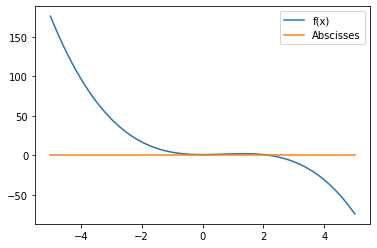

fuk_1 = 
1.00000000000000
f'uk_1 = 
11.0000000000000
uk = 
0.909090909090909
f_uk = 0
0.909090909090909
fuk_1 = 
0.909090909090910
f'uk_1 = 
11.0000000000000
uk = 
0.826446280991735
f_uk = 0
0.826446280991735
fuk_1 = 
0.826446280991735
f'uk_1 = 
11.0000000000000
uk = 
0.751314800901578
f_uk = 0
0.751314800901578
fuk_1 = 
0.751314800901578
f'uk_1 = 
11.0000000000000
uk = 
0.683013455365071
f_uk = 0
0.683013455365071
fuk_1 = 
0.683013455365070
f'uk_1 = 
11.0000000000000
uk = 
0.620921323059155
f_uk = 0
0.620921323059155
fuk_1 = 
0.620921323059155
f'uk_1 = 
11.0000000000000
uk = 
0.564473930053777
f_uk = -8.88178419700125e-16
0.564473930053777
fuk_1 = 
0.564473930053777
f'uk_1 = 
11.0000000000000
uk = 
0.513158118230707
f_uk = 0
0.513158118230707
fuk_1 = 
0.513158118230707
f'uk_1 = 
11.0000000000000
uk = 
0.466507380209733
f_uk = -8.88178419700125e-16
0.466507380209733
fuk_1 = 
0.466507380209733
f'uk_1 = 
11.0000000000000
uk = 
0.424097618372485
f_uk = 0
0.424097618372485
fuk_1 = 
0.42409

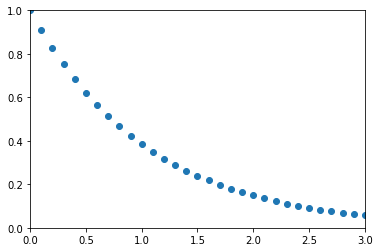

In [71]:
fig, ax = plt.subplots()
x_ = np.linspace(-5, 5)
y = 2*x_**2 - x_**3 + 1
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
plt.show()

dudt = u.diff(t)
expr = sp.Eq(dudt, -u)
res = FirstModel(-u, 1)

absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])
plt.ylim([0, 1])
plt.xlim([0, 3])
plt.scatter(absi, coords)

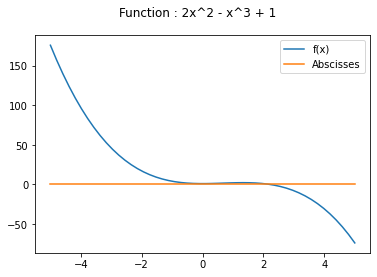

NameError: name 'x' is not defined

In [7]:
fig, ax = plt.subplots()
x_ = np.linspace(-5, 5)
y = 2*x_**2 - x_**3 + 1
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
fig.suptitle('Function : 2x^2 - x^3 + 1')
plt.show()

vec = 2*x**2 - x**3 + 1
res = FirstModel(vec, 10)
print(res)
absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])

plt.ylim([-10, 10])
plt.xlim([0, 3])
plt.scatter(absi, coords)



In [ ]:
fig, ax = plt.subplots()
x_ = np.linspace(-5, 5)
y = 15*x_**(2) + 5*x_+ 15*x_**(3)
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
fig.suptitle('Function : 15 x^2+5 x+15 x^3')
plt.show()

vec = 15*x**(2) + 5*x + 15*x**(3)
res = FirstModel(vec, 1)
print(res)

absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])

plt.ylim([-10, 10])
plt.xlim([0, 3])
plt.scatter(absi, coords)


In [ ]:
fig, ax = plt.subplots()
x_ = np.linspace(-5, 5)
y = np.cos(x_) - x_**3
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
fig.suptitle('Wikipedia example : cos(x) - x^3 = 0')
plt.show()

vec = sp.cos(x) - x**3
res = FirstModel(vec, 1, 3)
print(res)